# Report 2: Augmented Cellular Automata Exploration
## Srihith Jarabana
### CSB195 Fall 2025


**Purpose**: This notebook explores the behavior of augmented cellular automata (ACA) where multiple Wolfram rules coexist and interact. The goal is to investigate conditions that lead to sustained, complex behavior reminiscent of living systems.

**Approach**: I examined complex behaviour (Rule 110 as Class 4) as when embedded (i.e. overlay) in maximum chaos (Rule 90 as Class 3 acting as a background), allowing them to interact through preset augmenters, demonstrating the strength of computational complexity.



## AI Conversation Links
- Gemini 2.5 Pro: https://gemini.google.com/share/8d2c44d606c4



## Notebook Structure
1. **Cell 1**: Global configuration variables
2. **Cell 2**: Helper functions 
3. **Cell 3**: World initialization
4. **Cell 4**: Augmenter definitions and world evolution
5. **Cell 5**: Density analysis
6. **Cell 6**: Complexity analysis
7. **Cell 7**: References

---

### Results & Interpretation

**Observations**:
- The plot as seen in the HTML visuaization is dominated by the rather chaotic, seemingly grainy texture of the Rule 90 background (dark grey). However, within this chaos are clear and interacting "structures" represented by State 2 (bright red).
- The background (Rule 90) clearly exhibits the behaviours of Class 3 (i.e. chaotic and fractal) whiel the overlay (Rule 110) is more distinct and coherent (similar to Class 4). 
- State 2 (Rule 110) seems to persist for the entire process, even expanding near the end. 
- Likewise, it creates sustained and interacting structures: it does not disperse randomly. The red is not dispersed randomly in the black background but rather together. 
- The pattern shows traits consistent with Rule 110 such as glider-trajectories (Cook 2004). 

**Quantitative Analysis**:
- **Density**: State 2 density stabilized to roughly 0.1
- **Entropy**: High indicating complex behavior
- **Compression ratio**: Roughly 0.8 suggests Class 4 (complex) behaviour
- **Correlation length**: Short (roughly 0.5-2.0 cells) means locally chaotic (Class 3-dominated) behavior

**Interpretation**:
- The behavior is really  interesting because it demonstrates the emergence of Class 4 complexity (computation) from a chaotic (Class 3) environment.
- The system settles into the "Edge of Chaos," the regime believed to maximize computational potential (Langton 1990).
- Local chaos (i.e. short correlation) provides the activity, while global structure (i.e. high entropy, low compressibility) maintains the patterns.

**Connection to Life**:
- The Rule 110 structures resists dissipation, and maintains stable density and integrity, acting like a non-equilibrium system that organizes itself against the environment.
- In principle, it is able to adapt, as the structures are defined by interactions that process information (Martínez and Mora 2003). 
- Perfectly balanced, with the chaotic Rule 90 providing the dynamic and active background and the complex Rule 110 having the structural order.

**Conclusion**:
- The computational power of Rule 110 is strong enough to consistently dominate the chaotic Rule 90 background.
- The experiment supports the idea that stable structures can spontaneously emerge and persist within a random environment.

In [1]:
# =====================================================================
# CELL 1: Global Configuration Variables
# =====================================================================
#
# Define the parameters for the world.
# These globals will be read by the init_world() function (defined in Cell 2)
# when it's called in Cell 3.
#
# --- Experiment Parameters ---
WIDTH  = 217           # Spatial width (x)
STEPS  = 434           # Number of time steps (y) -> results in STEPS+1 rows
# Note: WIDTH=217, STEPS=434 as requested

# --- Rule Definitions ---
RULE   = 90            # Background rule (Class 3, chaotic)
# Rule 110 (Class 4, complex) is implemented via Augmenters in Cell 4

# --- World Setup ---
BOUNDARY = 'fixed'     # 'fixed' or 'periodic' (fixed is required for this experiment)
RANDOM_SEED = 12345    # Use a specific seed for reproducible results
INIT_MODE = 'random'   # 'random' (for background)
INIT_DENSITY = 0.5     # Used for 'random' mode

# --- Palette Definition ---
# Define colors for all states. We need 0, 1, and 2.
PALETTE = {
    0: "#FFFFFF",   # state 0 -> OFF (white)
    1: "#404040",   # state 1 -> Background ON (dark gray)
    2: "#E63946"    # state 2 -> Rule 110 ON (vibrant red)
}

print("Cell 1: Global configuration loaded.")
print(f"  World: {WIDTH}w x {STEPS}h, Rule: {RULE} (BG), Boundary: {BOUNDARY}")
print(f"  Init: {INIT_MODE} @ {INIT_DENSITY*100}% density, Seed: {RANDOM_SEED}")

Cell 1: Global configuration loaded.
  World: 217w x 434h, Rule: 90 (BG), Boundary: fixed
  Init: random @ 50.0% density, Seed: 12345


In [5]:
# =====================================================================
# CELL 2: Helper functions (from ACA_lab.v3.ipynb)
# =====================================================================
#
# This cell contains all code from Cell 1 (Imports) and Cell 2 (Helpers)
# of the provided ACA_lab.v3.ipynb notebook.
#
# --- [Code from original Cell 1: Imports] ---

import subprocess, sys, importlib

# External packages used in this notebook
REQUIRED_PACKAGES = ['numpy', 'matplotlib', 'tqdm']  

print(f"Checking for required packages: {', '.join(REQUIRED_PACKAGES)}...")

for package in REQUIRED_PACKAGES:
    try:
        importlib.import_module(package)
        print(f"'{package}' found.")
    except ImportError:
        print(f"'{package}' not found. Attempting installation...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"'{package}' installed successfully.")
        except Exception as e:
            print(f"ERROR: Could not install '{package}'. Please run 'python -m pip install {package}' manually.")
            raise e

# Final imports (after ensuring availability)
import numpy as np
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline")  # inline figures in notebook
import matplotlib.pyplot as plt
from tqdm.auto import tqdm # Use tqdm.auto for broad compatibility
from pathlib import Path
from IPython.display import display

# Sanity info
print("All dependencies are ready.")
print("NumPy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)

# Simple capability check: filesystem writability
out_dir = Path("./ACA_outputs")
out_dir.mkdir(exist_ok=True)
print("Output directory:", out_dir.resolve())
print("Filesystem writable:", out_dir.exists() and out_dir.is_dir())


# --- [Code from original Cell 2: Helpers] ---

from dataclasses import dataclass, asdict
from typing import Literal, Dict, Any
from pathlib import Path
import numpy as np
import json
import base64
import webbrowser, os


NeighborhoodOrderDoc = "Neighborhood bit ordering is 111,110,101,100,011,010,001,000 (Wolfram canonical)."

def rule_to_bitstring(rule: int) -> str:
    """
    Convert Wolfram ECA rule number (0..255) to an 8-char '0'/'1' bitstring.
    Order: 111,110,101,100,011,010,001,000 (MSB for '111').
    """
    if not (0 <= rule <= 255):
        raise ValueError("Rule must be in [0, 255].")
    return format(rule, '08b')


def bitstring_to_rule(bits: str) -> int:
    """
    Convert an 8-char '0'/'1' bitstring (ordered 111..000) to Wolfram rule int.
    """
    if len(bits) != 8 or any(c not in '01' for c in bits):
        raise ValueError("Bitstring must be 8 chars of '0'/'1'.")
    return int(bits, 2)

# Precompute mapping from neighborhood (3-bit index) to output for speed
def _rule_lookup(rule: int) -> np.ndarray:
    bits = rule_to_bitstring(rule)
    # map order 111..000 to integer indices 7..0
    return np.array([int(ch) for ch in bits], dtype=np.uint8)

def apply_rule(neighborhood: tuple[int, int, int], rule: int) -> int:
    """
    Core ECA transition for a single neighborhood.
    Any non-zero inputs are treated as 1.
    """
    l, c, r = (1 if x else 0 for x in neighborhood)  # booleanize
    idx = (l << 2) | (c << 1) | r                    # 0..7 for 111..000 is 7..0
    return int(_rule_lookup(rule)[7 - idx])          # flip to align 111..000

def make_lookup(rule: int) -> np.ndarray:
    """Precompute 8-bit lookup (ordered 111,110,...,000)."""
    return _rule_lookup(rule)

def eca_next(row: np.ndarray, boundary: str, lookup: np.ndarray) -> np.ndarray:
    """
    Vectorized one-step ECA update for an entire row.
    Any non-zero value in `row` counts as 1 (True) for rule evaluation.
    Returns uint8 array with values in {0,1}.
    """
    # --- PATCH: booleanize once, then build neighborhoods on the mask ---
    rb = (row != 0).astype(np.uint8)

    if boundary == 'periodic':
        L = np.roll(rb, +1); C = rb; R = np.roll(rb, -1)
    elif boundary == 'fixed':
        W = rb.shape[0]
        L = np.empty_like(rb); L[0]  = 0; L[1:]  = rb[:-1]
        C = rb
        R = np.empty_like(rb); R[-1] = 0; R[:-1] = rb[1:]
    else:
        raise ValueError("Unknown boundary. Use 'periodic' or 'fixed'.")

    # index 0..7 (00b..111b) computed from booleanized bits
    idx = (L << 2) | (C << 1) | R
    # lookup[0] == output for '111', lookup[7] for '000' → use 7-idx
    return lookup[7 - idx].astype(np.uint8)

# (nice-to-have convenience wrapper)
def eca_step(row: np.ndarray, rule: int, boundary: str = 'periodic') -> np.ndarray:
    """Convenience wrapper (uses booleanized evaluation as above)."""
    return eca_next(row, boundary, make_lookup(rule))


@dataclass               # Using the @dataclass "decorator" to simplify the creation of ...
class World:             # ... the class "World".
    width: int
    steps: int           # a state has steps+1 rows (including t0)
    rule: int            # the Wolfram code that makes this world
    boundary: Literal['periodic','fixed'] = 'periodic'
    seed: int | None = None
    init_mode: Literal['single_on_center','random'] = 'single_on_center'
    init_density: float = 0.5
    palette: Dict[int, str] | None = None
    # the two planes
    state: np.ndarray | None = None
    appearance: np.ndarray | None = None

    def __post_init__(self):
        # --- Require a palette (fail fast) ---
        if self.palette is None:
            raise ValueError(
                "World.palette is required. Define PALETTE in Cell 1 and pass it to World(...). "
                "Example: {0:'#FFFFFF', 1:'#427dae'}"
            )
        _validate_palette(self.palette)  # see helper below
        # Eagerly allocate arrays (the state- and appearance- planes)
        if self.state is None:
            self.state = np.zeros((self.steps + 1, self.width), dtype=np.uint8)
        if self.appearance is None:
            self.appearance = np.zeros((self.steps + 1, self.width), dtype=np.int16)

    # --- JSON (de)serialization helpers ---
    def to_json_dict(self) -> dict:
        """Convert world (config + data) to a JSON-serializable dict."""
        # Note: Dataclass config is already serializable
        config = asdict(self)
        # Handle non-serializable ndarrays
        config['state'] = config['state'].tolist()
        config['appearance'] = config['appearance'].tolist()
        return config

    @classmethod
    def from_json_dict(cls, d: dict) -> 'World':
        """Recreate a World instance from a dict (e.g., from JSON)."""
        # Create a new world with config, which allocates empty arrays
        w = cls(
            width=int(d['width']),
            steps=int(d['steps']),
            rule=int(d['rule']),
            boundary=d.get('boundary', 'periodic'),
            seed=d.get('seed', None),
            init_mode=d.get('init_mode', 'single_on_center'),
            init_density=float(d.get('init_density', 0.5)),
            palette=d.get('palette', {0: "#FFFFFF", 1: "#427dae", 2: "#ffc107"})
        )
        # Overwrite with stored arrays
        w.state = np.array(d['state'], dtype=np.uint8)
        w.appearance = np.array(d['appearance'], dtype=np.int16)
        return w


def save_world_json(world: World, path: str | Path) -> Path:
    p = Path(path)
    p.parent.mkdir(parents=True, exist_ok=True)
    with p.open('w', encoding='utf-8') as f:
        json.dump(world.to_json_dict(), f)
    return p

def load_world_json(path: str | Path) -> World:
    p = Path(path)
    with p.open('r', encoding='utf-8') as f:
        d = json.load(f)
    return World.from_json_dict(d)

# --- Validators ---
def _validate_palette(palette: dict[int, str]) -> None:
    if not isinstance(palette, dict):
        raise ValueError("Palette must be a dict mapping int -> hex color string.")
    for k, v in palette.items():
        if not isinstance(k, int):
            raise ValueError(f"Palette key {k!r} is not int.")
        if not (isinstance(v, str) and v.startswith('#') and len(v) in (7, 9)):
            raise ValueError(f"Palette value for key {k} must be '#RRGGBB' or '#RRGGBBAA', got {v!r}.")
        try:
            int(v[1:], 16)
        except Exception:
            raise ValueError(f"Palette color {v!r} is not valid hex.")
    # strictly require keys 0 and 1 
    required = {0, 1}
    missing = required - set(palette.keys())
    if missing:
        raise ValueError(f"Palette is missing required indices: {sorted(missing)}")


# --- HTML rendering: write a self-contained viewer and (optionally) open it ---
def render_html_view(world: World, out_html: str | Path) -> Path:
    import time, os

    t0 = time.perf_counter()
    
    # Choose byte width: 1 byte is enough if your palette indices < 256.
    max_index = int(np.max(world.appearance))
    dtype = np.uint8 if max_index < 256 else np.uint16
    appearance_flat = world.appearance.astype(dtype, copy=False).ravel(order="C")
    b64 = base64.b64encode(appearance_flat.tobytes()).decode("ascii")
    t1 = time.perf_counter()
    
    data_small = {
        "dtype": "u8" if dtype is np.uint8 else "u16",
        "width": world.width,
        "rows": world.steps + 1,
        "palette": world.palette,
        "meta": {
            "rule": world.rule,
            "boundary": world.boundary,
            "seed": world.seed,
            "init_mode": world.init_mode,
            "init_density": world.init_density
        }
    }
    html_template = f"""<!doctype html>
<html>
<head>
<meta charset="utf-8">
<title>ACA Trajectory (Rule {world.rule})</title>
<style>
  body {{ margin: 0; font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; }}
  #bar {{ padding: 8px 12px; display: flex; gap: 12px; align-items: center; border-bottom: 1px solid #ddd; }}
  #info {{ font-size: 14px; opacity: .8; }}
  #canvas {{ display: block; }}
  button, input {{ font-size: 14px; }}
  .mono {{ font-family: ui-monospace, SFMono-Regular, Menlo, Consolas, monospace; }}
</style>
</head>
<body>
  <div id="bar">
    <span id="info"></span>
    <label>Scale: <input id="scale" type="number" step="1" min="1" value="4" style="width:60px;"></label>
    <button id="fit">Fit to window</button>
    <button id="square">Square pixels</button>
    <span class="mono">Palette: {json.dumps(world.palette)}</span>
  </div>
  <canvas id="canvas"></canvas>
  <script id="appearance_b64" type="application/octet-stream">
  {b64}
  </script>
<script>
const data = {json.dumps(data_small)};   
const canvas = document.getElementById('canvas');
const ctx = canvas.getContext('2d', {{alpha:false}});
const info = document.getElementById('info');
const scaleInput = document.getElementById('scale');

const rows = data.rows, cols = data.width, palette = data.palette;

// ---- decode base64 -> typed array (flat A of length rows*cols) ----

const b64 = document.getElementById('appearance_b64').textContent.trim();

function b64ToUint8(b64) {{
  const bin = atob(b64);
  const out = new Uint8Array(bin.length);
  for (let i = 0; i < bin.length; i++) out[i] = bin.charCodeAt(i);
  return out;
}}

console.time("decode");
const buf8 = b64ToUint8(b64);
const A = (data.dtype === "u8") ? buf8 : new Uint16Array(buf8.buffer);
console.timeEnd("decode");
console.log("A length:", (data.dtype==="u8"?buf8.length:new Uint16Array(buf8.buffer).length), "expected:", rows*cols);


// ---- palette packed to Uint32 (AABBGGRR in little-endian) ----
function hexToRgba(hex) {{
  hex = String(hex).trim().replace(/^#/, '');
  if (hex.length === 3)  hex = hex.split('').map(c => c+c).join('') + 'FF';
  else if (hex.length === 4) hex = hex.split('').map(c => c+c).join('');
  else if (hex.length === 6) hex += 'FF';
  if (hex.length !== 8) return [0,0,0,255];
  return [
    parseInt(hex.slice(0,2),16), parseInt(hex.slice(2,4),16),
    parseInt(hex.slice(4,6),16), parseInt(hex.slice(6,8),16)
  ];
}}
const maxKey = Math.max(...Object.keys(palette).map(k => parseInt(k,10)));
const pal32 = new Uint32Array(maxKey + 1);
for (const [k,v] of Object.entries(palette)) {{
  const [r,g,b,a] = hexToRgba(v);
  pal32[parseInt(k,10)] = (a<<24)|(b<<16)|(g<<8)|(r<<0);
}}

// ---- 1× base canvas + fast draw (then scale) ----
const base = document.createElement('canvas');
const bctx = base.getContext('2d', {{alpha:true}});
base.width = cols; base.height = rows;

function draw(scale) {{
  const img = bctx.createImageData(cols, rows);
  const buf32 = new Uint32Array(img.data.buffer);
  let p = 0;
  for (let y = 0; y < rows; y++) {{
    const rowOff = y * cols;
    for (let x = 0; x < cols; x++) {{
      buf32[p++] = pal32[A[rowOff + x]] || 0xFF000000;
    }}
  }}
  bctx.putImageData(img, 0, 0);

  canvas.width = cols * scale;
  canvas.height = rows * scale;
  ctx.imageSmoothingEnabled = false;
  ctx.drawImage(base, 0, 0, canvas.width, canvas.height);

  info.textContent = "Rule " + data.meta.rule +
                     " | boundary=" + data.meta.boundary +
                     " | seed=" + data.meta.seed +
                     " | init=" + data.meta.init_mode;
}}


document.getElementById('fit').addEventListener('click', () => {{
  const sX = Math.max(1, Math.floor(window.innerWidth / cols));
  const sY = Math.max(1, Math.floor((window.innerHeight-48) / rows));
  const s = Math.max(1, Math.min(sX, sY));
  scaleInput.value = s;
  draw(s);
}});

document.getElementById('square').addEventListener('click', () => {{
  const s = parseInt(scaleInput.value || '4', 10);
  draw(Math.max(1, s));
}});

scaleInput.addEventListener('change', () => {{
  const s = parseInt(scaleInput.value || '4', 10);
  draw(Math.max(1, s));
}});

console.time("draw");
draw(parseInt(scaleInput.value, 10));
console.timeEnd("draw");


</script>
</body>
</html>"""

    t2 = time.perf_counter()
    
    out_html = Path(out_html)
    out_html.parent.mkdir(parents=True, exist_ok=True)
    out_html.write_text(html_template, encoding='utf-8')

    size_kb = os.path.getsize(out_html) / 1024
    t3 = time.perf_counter()
    
    print(f"[render_html_view] b64: {(t1-t0)*1000:.1f} ms | template: {(t2-t1)*1000:.1f} ms | write: {(t3-t2)*1000:.1f} ms | size: {size_kb:.1f} KB")
    
    return out_html


def open_html(path: str | Path):
    """Try to open the given HTML file in a new browser tab/window (local setups)."""

    import time, webbrowser
    
    url = Path(path).resolve().as_uri()

    t0 = time.perf_counter()
    ok = webbrowser.open_new_tab(url)
    t1 = time.perf_counter()
    print(f"[open_html] launch: {(t1-t0)*1000:.1f} ms | ok={ok} | URL: {url}")
    print("Opened in browser:" if ok else "Could not auto-open; open manually:", url)

# --- Utility: prettify a rule ---
def describe_rule(rule: int) -> str:
    bits = rule_to_bitstring(rule)
    return f"Rule {rule} (bits {bits}) | {NeighborhoodOrderDoc}"

def parse_grid(g) -> np.ndarray:
    """
    Accepts:
      - "1011"  (1×W string)
      - "10\\n11" (H×W string, bottom line is 'now')
      - np.ndarray[int] (H×W or (W,) -> coerced to (1×W))
    Returns: int ndarray of shape (H, W) with values as given (no coercion to {0,1}).
    """
    if isinstance(g, np.ndarray):
        arr = g.astype(int, copy=False)
        if arr.ndim == 1:
            arr = arr[np.newaxis, :]
        elif arr.ndim != 2:
            raise ValueError("Grid ndarray must be 1D or 2D.")
        return arr
    if not isinstance(g, str):
        raise ValueError("Grid must be a string or numpy array.")
    # Split lines; ignore empty lines; bottom line is 'now'
    rows = [ln.strip() for ln in g.strip().splitlines() if ln.strip() != ""]
    if len(rows) == 1 and all(ch in "0123456789" for ch in rows[0]):
        data = [[int(ch) for ch in rows[0]]]
    else:
        data = [[int(ch) for ch in ln] for ln in rows]
    # Validate rectangular
    Wset = {len(r) for r in data}
    if len(Wset) != 1:
        raise ValueError("All grid rows must have same width.")
    return np.array(data, dtype=int)

def _candidate_anchors(width: int, patch_width: int, periodic: bool) -> np.ndarray:
    if periodic:
        return np.arange(width, dtype=int)
    # non-periodic: only anchors fully inside the segment
    max_start = width - patch_width
    if max_start < 0:
        return np.empty(0, dtype=int)
    return np.arange(max_start + 1, dtype=int)

def _slice_x(arr_row: np.ndarray, x0: int, w: int, periodic: bool) -> np.ndarray:
    """Return arr_row[x0:x0+w] with wrap if periodic; caller guarantees bounds otherwise."""
    W = arr_row.shape[0]
    if periodic:
        idx = (np.arange(x0, x0 + w) % W)
        return arr_row[idx]
    else:
        # out-of-bounds anchors must not be produced upstream
        return arr_row[x0:x0 + w]

def match_at_t(world, plane: str, t: int, pattern: np.ndarray) -> np.ndarray:
    """
    Find anchors x0 where pattern (H×W) matches rows [t-H+1 ... t] on the given plane.
    Inherits wrap from world.boundary. Returns int array of anchors (possibly empty).
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    pat = parse_grid(pattern)
    H, Wp = pat.shape
    if t + 1 < H:
        return np.empty(0, dtype=int)

    A = getattr(world, plane)  # shape (steps+1, width)
    width = world.width
    periodic = (world.boundary == 'periodic')

    anchors = _candidate_anchors(width, Wp, periodic)
    if anchors.size == 0:
        return anchors

    # Start with all candidates valid; knock out mismatches row by row
    ok = np.ones(anchors.shape[0], dtype=bool)
    # rows in the world corresponding to pattern rows (top..bottom) = (t-H+1 .. t)
    row_indices = range(t - H + 1, t + 1)

    for h, r in enumerate(row_indices):
        row = A[r]  # (width,)
        # Build window slices for all candidate anchors
        # windows[k] = row slice at anchor k (length Wp)
        if periodic:
            idx = (anchors[:, None] + np.arange(Wp)) % width  # shape (K, Wp)
            windows = row[idx]                                # shape (K, Wp)
            eq = np.all(windows == pat[h], axis=1)            # (K,)
        else:
            # In non-periodic, anchors already in-bounds
            # vectorized gather via broadcasting
            idx = anchors[:, None] + np.arange(Wp)            # (K, Wp)
            windows = row[idx]
            eq = np.all(windows == pat[h], axis=1)
        ok &= eq
        if not ok.any():
            return np.empty(0, dtype=int)
    return anchors[ok]

def match_at_row(world, plane: str, t_ref: int, pattern: np.ndarray) -> np.ndarray:
    """
    Find anchors x0 where pattern (H×W) matches rows [t_ref-H+1 ... t_ref] on plane.
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    pat = parse_grid(pattern)
    H, Wp = pat.shape  # <-- Wp is defined here (Pattern Width)
    if t_ref + 1 < H:
        return np.empty(0, dtype=int)

    A = getattr(world, plane)
    width = world.width
    periodic = (world.boundary == 'periodic')

    anchors = _candidate_anchors(width, Wp, periodic)
    if anchors.size == 0:
        return anchors

    ok = np.ones(anchors.shape[0], dtype=bool)
    for h, r in enumerate(range(t_ref - H + 1, t_ref + 1)):
        row = A[r]
        if periodic:
            idx = (anchors[:, None] + np.arange(Wp)) % width
            windows = row[idx]
        else:
            # THIS IS THE CORRECTED LINE:
            idx = anchors[:, None] + np.arange(Wp) # <-- Was WT, now Wp
            windows = row[idx]
        ok &= np.all(windows == pat[h], axis=1)
        if not ok.any():
            return np.empty(0, dtype=int)
    return anchors[ok]

    
def apply_patch(world, plane: str, t: int, x0: int, patch: np.ndarray) -> None:
    """
    Overwrite rows [t-H+1 ... t], columns [x0 ... x0+W-1] with 'patch' (H×W).
    Wraps horizontally if world.boundary == 'periodic'. Fail-fast on invalid palette indices.
    """
    if plane not in ("state", "appearance"):
        raise ValueError("plane must be 'state' or 'appearance'")
    P = parse_grid(patch)
    H, Wp = P.shape
    if t + 1 < H:
        return  # not enough history yet
    A = getattr(world, plane)
    width = world.width
    periodic = (world.boundary == 'periodic')

    # Appearance palette coverage (fail-fast)
    if plane == "appearance":
        palette_keys = set(world.palette.keys())
        used = set(int(v) for v in np.unique(P))
        if not used.issubset(palette_keys):
            missing = sorted(used - palette_keys)
            raise ValueError(f"Appearance patch uses indices not in palette: {missing}")

    # Write row by row (vectorized along x via index arrays)
    for h, r in enumerate(range(t - H + 1, t + 1)):
        if periodic:
            idx = (np.arange(x0, x0 + Wp) % width)
            A[r, idx] = P[h]
        else:
            if x0 < 0 or x0 + Wp > width:
                # out-of-bounds anchors should not have been produced
                continue
            A[r, x0:x0 + Wp] = P[h]


# ---- World factory (fresh world from config) ----
def init_world() -> World:
    """(Re)initialize the World using globals defined in Cell 1."""
    global WIDTH, STEPS, RULE, BOUNDARY, RANDOM_SEED, INIT_MODE, INIT_DENSITY, PALETTE

    world = World(width=WIDTH, steps=STEPS, rule=RULE, boundary=BOUNDARY,
                  seed=RANDOM_SEED, init_mode=INIT_MODE,
                  init_density=INIT_DENSITY, palette=PALETTE)

    rng = np.random.default_rng(RANDOM_SEED) if RANDOM_SEED is not None else np.random.default_rng()

    if INIT_MODE == 'single_on_center':
        t0 = np.zeros(WIDTH, dtype=np.uint8)
        t0[WIDTH // 2] = 1
    elif INIT_MODE == 'random':
        if not (0.0 <= INIT_DENSITY <= 1.0):
            raise ValueError("INIT_DENSITY must be in [0,1].")
        t0 = (rng.random(WIDTH) < INIT_DENSITY).astype(np.uint8)
    else:
        raise ValueError(f"Unknown INIT_MODE: {INIT_MODE}")

    world.state[0] = t0
    world.appearance[0] = t0.astype(np.int16)

    print(describe_rule(RULE))
    print(f"World initialized: width={WIDTH}, steps={STEPS}, boundary={BOUNDARY}, "
          f"init={INIT_MODE}, seed={RANDOM_SEED}")
    return world


# ---- Prepare augmenters, merging pal_add with optional recolor ----
def prepare_augmenters(world: World, augs: list[dict]) -> list[dict]:
    prepped, additions = [], {}
    for i, spec in enumerate(augs):
        if not spec.get("enable", True):
            continue

        # palette additions (as before)
        for k, v in (spec.get("pal_add") or {}).items():
            k, v = int(k), str(v)
            if k in additions and additions[k] != v:
                raise ValueError(f"Augmenter {i} conflicts on palette[{k}]")
            additions[k] = v

        # normalize apply to a list
        applies = spec.get("apply")
        if isinstance(applies, dict):
            applies = [applies]
        if not isinstance(applies, list) or not applies:
            raise ValueError(f"Augmenter {i}: 'apply' must be a dict or nonempty list of dicts.")

        # parse grids & offsets
        m = spec["match"]
        pat = parse_grid(m["grid"])
        m_row_off = int(m.get("row_offset", 0))

        parsed_applies = []
        for a in applies:
            trg = a["grid"]
            if isinstance(trg, str) and len(trg) >= 2 and trg[0] in "+-" and trg[1:].isdigit():
                appl = pat + int(trg)
            else:
                appl = parse_grid(trg)
            if appl.shape != pat.shape and appl.shape != (1,1):
                # allow 1×1 “paint here” patches; otherwise shapes must match
                raise ValueError(f"Augmenter {i}: pattern/apply shape mismatch: {pat.shape} vs {appl.shape}")
            parsed_applies.append({
                "plane": a["plane"],
                "grid": appl,
                "row_offset": int(a.get("row_offset", 0)),
                "dx": int(a.get("x_offset", 0)), 
            })

        prepped.append({
            "match_plane": m["plane"],
            "pattern": pat,
            "match_row_offset": m_row_off,
            "applies": parsed_applies,
        })

    if additions:
        merged = {**world.palette, **additions}
        _validate_palette(merged)
        for k, v in additions.items():
            if k in world.palette and world.palette[k] != v:
                raise ValueError(f"Palette[{k}] already {world.palette[k]!r}, not {v!r}.")
        world.palette.update(additions)

    return prepped

def run_augmenters(world: World, t_now: int, prepared: list[dict]) -> None:
    for spec in prepared:
        t_match = t_now + spec.get("match_row_offset", 0)
        anchors = match_at_row(world, spec["match_plane"], t_match, spec["pattern"])
        if anchors.size == 0:
            continue
        periodic = (world.boundary == 'periodic')
        W = world.width
        for x0 in anchors.tolist():
            for ap in spec["applies"]:
                t_apply = t_now + ap.get("row_offset", 0)
                dx = ap.get("dx", 0)
                x_apply = (x0 + dx) % W if periodic else (x0 + dx)
                # (Optional) guard fixed boundary writes that fall off the edge
                if not periodic and (x_apply < 0 or x_apply >= W):
                    continue
                apply_patch(world, ap["plane"], t_apply, x_apply, ap["grid"])

Checking for required packages: numpy, matplotlib, tqdm...
'numpy' found.
'matplotlib' found.
'tqdm' found.
All dependencies are ready.
NumPy: 2.3.4
Matplotlib: 3.10.7
Output directory: C:\Users\srihi\Downloads\ACA_outputs
Filesystem writable: True


In [3]:
# =====================================================================
# CELL 3: World Initialization
# =====================================================================
#
# This cell calls init_world() (from Cell 2) which uses the 
# global variables defined in Cell 1 to create the 'world' object.
#
# We also add our specific experiment seeding here:
# 1. The background is initialized (randomly, per Cell 1).
# 2. We "plant" a single state 2 seed in the center of the first row.
#

print("Cell 3: Initializing world...")

# init_world() reads the globals from Cell 1 (WIDTH, STEPS, RULE, etc.)
world = init_world()

# --- Experiment Seeding ---
# The world is initialized (e.g., random 50% density for states 0/1).
# Now, we manually override the center cell of the first row (t=0)
# to plant our Rule 110 "seed" (state 2).

center_x = world.width // 2
world.state[0, center_x] = 2

# Ensure the appearance plane matches the new state
world.appearance[0] = world.state[0].astype(np.int16)

print(f"World created: {world.width}w x {world.steps+1}h")
print(f"Planted State 2 seed at t=0, x={center_x}")

# Display the first row to confirm
print("\nInitial state (t=0) snippet:")
snippet_width = 40
start = max(0, center_x - snippet_width // 2)
end = min(world.width, center_x + snippet_width // 2 + 1)
print(world.state[0, start:end])

Cell 3: Initializing world...
Rule 90 (bits 01011010) | Neighborhood bit ordering is 111,110,101,100,011,010,001,000 (Wolfram canonical).
World initialized: width=217, steps=434, boundary=fixed, init=random, seed=12345
World created: 217w x 435h
Planted State 2 seed at t=0, x=108

Initial state (t=0) snippet:
[1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 2 1 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1
 1 0 1 1]


In [6]:
# =====================================================================
# CELL 4: Augmenter Definition & World Evolution
# =====================================================================

import time
from pathlib import Path

# Check if we are in Google Colab
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# --- Augmenter Definitions ---

# This is the list of patterns that will "seed" a new state 2 cell.
# These patterns are derived from Rule 110's "ON" transitions
# (110, 101, 011, 010, 001) where "1" = any nonzero state (1 or 2),
# AND the neighborhood must contain at least one '2' to propagate.
#
# This list is taken directly from your prompt and the ACA_lab.v3.ipynb
# "Coexisting augmenter example".
RULE_110_ON_PATTERNS_WITH_STATE_2 = [
    "002", "020", "210", "012", "021", "102", "120", "201", "022", "202", "220"
]


AUGMENTERS = [
    # --- Augmenter 1: Implement Rule 110 for State 2 ---
    # This is a "list comprehension" that creates one augmenter
    # for each of our Rule 110 "ON" patterns.
    *[{
        "enable": True,
        "match": {
            "plane": "state",
            "grid": pat,
            "row_offset": -1  # Match in the *previous* row (t-1)
        },
        "apply": [{
            "plane": "state",        # Write to the state plane
            "grid": "2",             # Write a single "2"
            "row_offset": 0,         # Write to the *current* row (t)
            "x_offset": 1            # Write in the center of the 3-cell pattern
        }],
        "pal_add": {2: PALETTE[2]} # Ensure palette has state 2
    } for pat in RULE_110_ON_PATTERNS_WITH_STATE_2],

    # --- Augmenter 2: Mirror State 2 to Appearance ---
    # This augmenter finds any '2' in the state plane (at time t)
    # and ensures it's also a '2' in the appearance plane (at time t)
    # so it gets the correct color.
    {
        "enable": True,
        "match": {
            "plane": "state",
            "grid": "2",
            "row_offset": 0     # Match in the current row
        },
        "apply": [{
            "plane": "appearance",
            "grid": "2",
            "row_offset": 0     # Write to the current row
        }],
        "pal_add": {2: PALETTE[2]}
    }
]

print(f"Cell 4: Defined {len(AUGMENTERS)} augmenters ({len(RULE_110_ON_PATTERNS_WITH_STATE_2)} for R110 logic + 1 for appearance).")


# --- Evolution Function ---
# This function (from ACA_lab.v3.ipynb, Cell 4) orchestrates the evolution.
def evolve(world: World, show_progress: bool = False) -> World:
    """
    Evolves the world step-by-step, applying the base rule (e.g., R90)
    and then running the augmenters.
    """
    T = world.steps
    lookup = make_lookup(world.rule)
    
    # Prepare augmenters (checks for palette errors, etc.)
    # This function IS in Cell 2.
    prepared_augs = prepare_augmenters(world, AUGMENTERS)

    iterator = range(T)
    if show_progress:
        # Use tqdm.auto from Cell 2 imports
        iterator = tqdm(iterator, desc="Evolving", leave=True)

    for t in iterator:
        # 1. Get the previous row
        prev = world.state[t]
        
        # 2. Compute the next row using the background rule (Rule 90)
        #    This rule booleanizes (treats 1 and 2 as "ON")
        nxt  = eca_next(prev, world.boundary, lookup)
        
        # 3. Write the background-computed state
        world.state[t+1] = nxt
        world.appearance[t+1] = nxt.astype(np.int16)

        # 4. Run augmenters to modify the new row (t+1)
        #    This is where our R110 logic overrides the R90 output.
        #    `t_now` is t+1, so offsets -1 (match) and 0 (apply) work.
        run_augmenters(world, t_now=t+1, prepared=prepared_augs)

    return world


# --- Run and Visualize ---
print("Starting evolution...")
t0 = time.perf_counter()

# Run the simulation
evolve(world, show_progress=True)

t1 = time.perf_counter()
print(f"Evolution complete. Took {t1-t0:.3f}s")

# Render the HTML visualization
html_filename = "R90_R110_trajectory.html"
html_path = render_html_view(world, f"./ACA_outputs/{html_filename}")
print("HTML written to:", Path(html_path).resolve())

# --- Open/Download HTML ---
if IN_COLAB:
    print(f"\nIn Google Colab. Use this code in a new cell to download the HTML file:")
    print(f"from google.colab import files\nfiles.download({str(html_path)!r})")
else:
    # Try to open in local browser
    try:
        print("Attempting to open HTML in default browser...")
        open_html(html_path)
    except Exception as e:
        print(f"Could not auto-open HTML in browser: {e}")

Cell 4: Defined 12 augmenters (11 for R110 logic + 1 for appearance).
Starting evolution...


Evolving: 100%|██████████| 434/434 [00:00<00:00, 694.40it/s]


Evolution complete. Took 0.632s
[render_html_view] b64: 1.0 ms | template: 0.1 ms | write: 2.8 ms | size: 127.3 KB
HTML written to: C:\Users\srihi\Downloads\ACA_outputs\R90_R110_trajectory.html
Attempting to open HTML in default browser...
[open_html] launch: 498.0 ms | ok=True | URL: file:///C:/Users/srihi/Downloads/ACA_outputs/R90_R110_trajectory.html
Opened in browser: file:///C:/Users/srihi/Downloads/ACA_outputs/R90_R110_trajectory.html


Cell 5: Running density analysis...


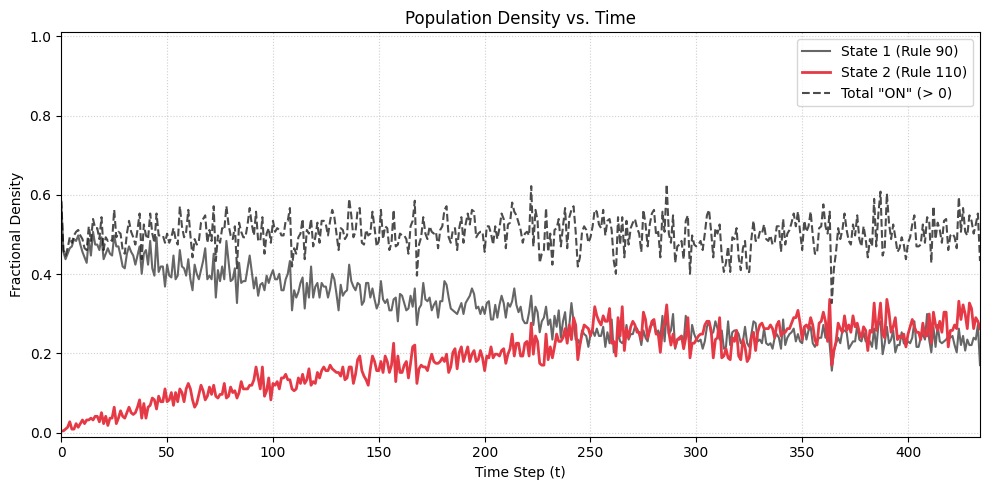

Saved density plot to: C:\Users\srihi\Downloads\ACA_outputs\density_analysis.png

Final Densities (at t=434):
  State 1 (R90): 0.1705
  State 2 (R110): 0.2627
  Total ON (>0): 0.4332
  OFF (==0):     0.5668


In [7]:
# =====================================================================
# CELL 5: Density Analysis
# =====================================================================
#
# Analyze the population density of each state over time.
# This is critical to see if State 2 (Rule 110) persists,
# dies out, or takes over.
#

import matplotlib.pyplot as plt
from pathlib import Path

print("Cell 5: Running density analysis...")

# Calculate densities for each state, for each time step
# (world.state has shape (STEPS+1, WIDTH))

# Density of State 0 (OFF)
dens_0 = (world.state == 0).mean(axis=1)
# Density of State 1 (Rule 90 background)
dens_1 = (world.state == 1).mean(axis=1)
# Density of State 2 (Rule 110 foreground)
dens_2 = (world.state == 2).mean(axis=1)
# Density of all "ON" cells (for booleanized metrics)
dens_on = (world.state > 0).mean(axis=1)

# --- Plotting ---

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)

# Plot the densities
ax.plot(dens_1, label='State 1 (Rule 90)', color=PALETTE.get(1, '#404040'), linewidth=1.5, alpha=0.8)
ax.plot(dens_2, label='State 2 (Rule 110)', color=PALETTE.get(2, '#E63946'), linewidth=2)
ax.plot(dens_on, label='Total "ON" (> 0)', color='#000000', linestyle='--', linewidth=1.5, alpha=0.7)

# --- Formatting ---
ax.set_xlabel("Time Step (t)")
ax.set_ylabel("Fractional Density")
ax.set_title("Population Density vs. Time")
ax.legend(loc='best')
ax.grid(True, linestyle=':', alpha=0.6)

# Set y-axis limit to [0, 1] as density is a fraction
ax.set_ylim(-0.01, 1.01)
# Set x-axis limit to the number of steps
ax.set_xlim(0, world.steps)

fig.tight_layout()

# Save and display
out_png = Path("./ACA_outputs/density_analysis.png")
fig.savefig(out_png, dpi=150)
display(fig)
plt.close(fig)

print(f"Saved density plot to: {out_png.resolve()}")

# Print final-state densities
print(f"\nFinal Densities (at t={world.steps}):")
print(f"  State 1 (R90): {dens_1[-1]:.4f}")
print(f"  State 2 (R110): {dens_2[-1]:.4f}")
print(f"  Total ON (>0): {dens_on[-1]:.4f}")
print(f"  OFF (==0):     {dens_0[-1]:.4f}")

# Information-based analysis and Interpreation (Cell 6)

The cell below computes a small **complexity dashboard** for the spacetime produced by the augmented CA.  
We report both **booleanized** statistics (treat any nonzero state as “on”) and **label-aware** statistics (that track the alternate-rule process explicitly, e.g., state==2).

## What we compute (per time step unless noted)

**Densities**
- `on(t)`: fraction of cells with state > 0 (booleanized “on”).
- `p1(t)`, `p2(t)`: fractions with state==1 and state==2, respectively.
  - *Why:* Separates the background fabric (1) from the alt track (2). If `p2` quickly drops to 0, the alt process dies out.

**Entropy**
- `H_bin(t)`: binary Shannon entropy of the row after booleanization.
  - 0 for all-0/all-1 rows; 1 for a perfectly balanced random row.
- `H_multi(t)`: multiclass entropy over the actual labels {0,1,2,…}.
  - *Why:* `H_bin` detects order vs. noise; `H_multi` shows how much “surprise” is carried specifically by the alt label.

**Spatial correlation length**
- `corr_len_bool(t)`: first lag where the row’s autocorrelation (booleanized) drops below `1/e`.
- `corr_len_alt(t)`: same but on the indicator field `1(state==2)`.
  - *Why:* Ordered domains have longer correlations; pure chaos decorrelates quickly. Class-4 regimes often show **intermediate, time-varying** correlation scales.

**Alt-front geometry**
- `count_2(t)`, `width_2(t)`, `com_2(t)` (center-of-mass), and `xmin/xmax`.
  - *Why:* A quick readout of whether the alt process persists, spreads, drifts, or fragments.

**2D block entropy (rolling)**
- `H_{h,w}(t)`: entropy of distinct `h×w` blocks over the last `h` rows (default 8×8), booleanized.
  - *Why:* Captures **spatiotemporal** variety; it rises with local pattern diversity.  
    - Low in periodic/Class-2.  
    - High but featureless in Class-3.  
    - **Intermediate/high and slowly saturating** is a common Class-4 signature (domains + interactions).

**Compression ratio (rolling)**
- `R_cmp(t)`: zlib compressed size / raw size for the last `L` rows (default 64), booleanized.
  - *Why:* A proxy for global regularity.  
    - Periodic/frozen ⇒ **very compressible** (low ratio).  
    - Random ⇒ **incompressible** (high ratio).  
    - Class-4 often sits **between** (repeating scaffolds + novel interactions).

**Row-to-row mutual information**
- `I(row_t, row_{t+1})` on booleanized rows.
  - *Why:* Measures how much information about the next row is contained in the current row.  
    - Very low in near-random regimes (Class-3).  
    - High in periodic/fixed regimes (Class-1/2).  
    - **Moderate, structured** values that fluctuate are typical of Class-4.

---

## How to read the dashboard (rules: background + seeded alt)

1. **Alt dies out quickly**
   - `p2(t) → 0`, `count_2` and `width_2` collapse.
   - `H_bin` may rise (if background is chaotic) or fall (if background is periodic).
   - `H_{8,8}` low or plateaus quickly; `R_cmp` either very low (ordered) or very high (chaotic).
   - `corr_len_bool` either grows (ordered) or stays short (chaotic).

2. **Alt persists but locks into order**
   - `p2(t)` stabilizes near a constant; `width_2` bounded.
   - `H_bin` moderate/low; `H_{8,8}` modest; `R_cmp` trends **low** (compressible).
   - Correlation lengths non-zero and often stable → Class-2-ish coexistence.

3. **Alt coexists with background chaos**
   - `p2(t)` > 0 with variability; `width_2` wanders; `com_2` drifts.
   - `H_bin` high, but `R_cmp` not maximal (some structure); `H_{8,8}` high and varies.
   - `corr_len_bool` short on average; `corr_len_alt` may show intermittent bursts → mixed Class-3/4.

4. **“Interesting” Class-4-like dynamics**
   - `p2` persists; `width_2` fluctuates; fronts collide/shed.
   - `H_{8,8}` elevated and grows with window size before saturating; `R_cmp` intermediate.
   - `corr_len_bool` and `I(row_t,row_{t+1})` are neither minimal nor maximal, and often **oscillate**.
   - Visual tell: domains, gliders/particles, defect interactions visible in the HTML trajectory.

---

Cell 6: Running complexity analysis...


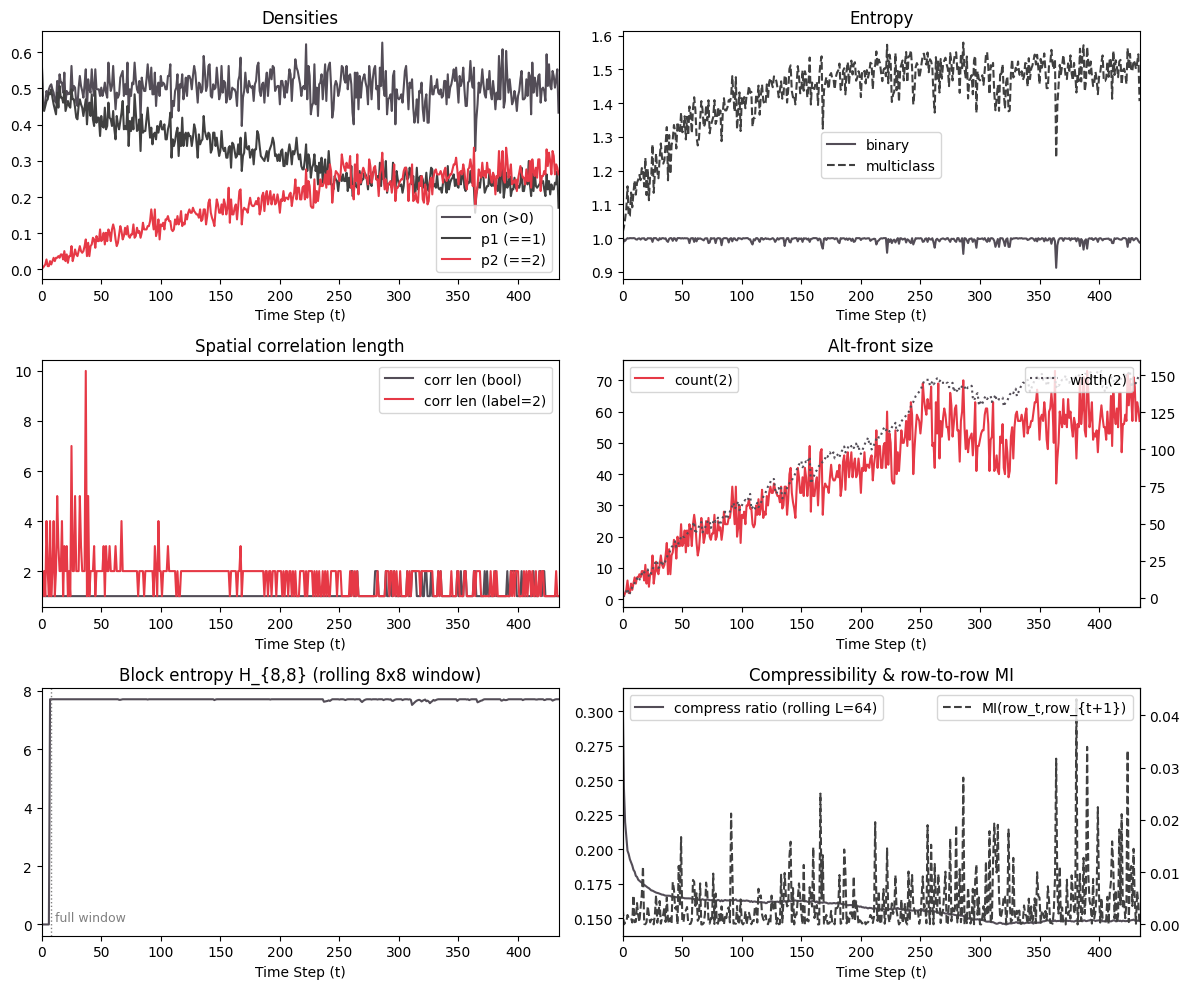

Saved complexity dashboard to: C:\Users\srihi\Downloads\ACA_outputs\complexity_dashboard.png


In [8]:
# =====================================================================
# CELL 6: Complexity Analysis (Code)
# =====================================================================

import numpy as np
import matplotlib.pyplot as plt
import zlib
from collections import Counter

print("Cell 6: Running complexity analysis...")

# colors, consistent with the pattern evolution
# This will automatically pick up the palette from Cell 1
COL = {
    "state1": world.palette.get(1, "#427dae"),
    "state2": world.palette.get(2, "#dd0044"),
    "joint":  "#534D57",
    "on":     "#534D57",
}

# consistent line widths and alpha
LW  = 1.5
ALP = 1.0

def ts_density(world):
    X = world.state
    T = X.shape[0]
    on = (X > 0).mean(axis=1)
    p1 = (X == 1).mean(axis=1)
    p2 = (X == 2).mean(axis=1)
    return on, p1, p2

def ts_entropy(world):
    X = world.state
    B = (X > 0).astype(np.uint8)
    # binary entropy per row
    p = B.mean(axis=1)
    # supress divide-by-zero warnings for p=0 or p=1
    with np.errstate(divide='ignore', invalid='ignore'):
        H_bin = -(p*np.log2(p)+(1-p)*np.log2(1-p))
    H_bin = np.nan_to_num(H_bin, nan=0.0) # set H(0) and H(1) to 0
    
    # multiclass entropy per row (over present labels)
    H_multi = np.empty(X.shape[0], dtype=float)
    for t,row in enumerate(X):
        vals, counts = np.unique(row, return_counts=True)
        ps = counts/row.size
        H_multi[t] = -np.sum(ps*np.log2(ps+1e-12))
    return H_bin, H_multi

def ts_corr_length(world, maxlag=128, label=None):
    """If label is None: booleanized; else: indicator for that label (e.g., 2)."""
    X = (world.state > 0).astype(np.float32) if label is None else (world.state == label).astype(np.float32)
    out = np.zeros(X.shape[0], dtype=float)
    threshold = 1.0 / np.e
    
    for t,row in enumerate(X):
        r_mean = row.mean()
        if r_mean == 0.0 or r_mean == 1.0: # Skip uniform rows
            out[t] = 0
            continue
            
        r = row - r_mean
        denom = float(np.dot(r, r)) + 1e-12
        cl = 0
        for lag in range(1, min(maxlag, row.size)):
            num = float(np.dot(r[:-lag], r[lag:]))
            if (num/denom) < threshold:
                cl = lag; break
        else: # if no break
            cl = maxlag
        out[t] = cl
    return out

def ts_alt_front(world, label=2):
    """Active count, min x, max x, width, center of mass for the alt label."""
    X = (world.state == label)
    T, W = X.shape
    count = X.sum(axis=1).astype(float)
    xmin = np.full(T, np.nan); xmax = np.full(T, np.nan)
    width = np.zeros(T, dtype=float); com = np.full(T, np.nan)
    xs = np.arange(W, dtype=float)
    for t in range(T):
        idx = np.flatnonzero(X[t])
        if idx.size:
            xmin[t], xmax[t] = idx[0], idx[-1]
            width[t] = xmax[t] - xmin[t] + 1
            com[t] = (idx.mean())
    return count, xmin, xmax, width, com

def block_entropy_last(world, h=8, w=8):
    """2D block entropy on the last h rows (booleanized); returns a scalar per time t >= h-1."""
    X = (world.state > 0).astype(np.uint8)
    T, W = X.shape
    if T < h or W < w:
        return np.zeros(T)
    
    H = np.zeros(T)
    # Start with an empty counter
    counts = Counter()
    
    # We use a rolling window approach for efficiency
    # This is a simplified version for clarity, not fully optimized rolling
    for t in range(h-1, T):
        slab = X[t-h+1:t+1]  # h×W
        counts.clear()
        for x in range(0, W-w+1):
            # tobytes() is a fast way to get a hashable key for the block
            counts[slab[:, x:x+w].tobytes()] += 1
            
        N = sum(counts.values())
        if N == 0:
            H[t] = 0.0
            continue
            
        ps = np.fromiter((c/N for c in counts.values()), dtype=float)
        H[t] = float(-(ps*np.log2(ps+1e-12)).sum())
    return H

def compress_ratio_last(world, L=64):
    """Compression ratio on a rolling slab of the last L rows (booleanized)."""
    X = (world.state > 0).astype(np.uint8)
    T = X.shape[0]
    R = np.zeros(T)
    for t in range(T):
        a = max(0, t-L+1)
        slab = X[a:t+1]
        if slab.size == 0:
            R[t] = 0.0
            continue
            
        raw = slab.tobytes()
        comp = zlib.compress(raw, 6)
        R[t] = len(comp) / max(1, len(raw))
    return R

def mutual_info_rows(world, bins=2):
    """Plug-in MI between row t and t+1 on booleanized field."""
    B = (world.state > 0).astype(np.uint8)
    T, W = B.shape
    I = np.zeros(T)
    
    # Pre-calculate log(W)
    log_W = np.log2(W)
    
    for t in range(T-1):
        x = B[t]; y = B[t+1]
        
        # Calculate marginal entropies H(X) and H(Y)
        p_x = x.mean()
        p_y = y.mean()
        
        with np.errstate(divide='ignore', invalid='ignore'):
            H_x = -(p_x * np.log2(p_x) + (1-p_x) * np.log2(1-p_x))
            H_y = -(p_y * np.log2(p_y) + (1-p_y) * np.log2(1-p_y))
        H_x = np.nan_to_num(H_x, nan=0.0)
        H_y = np.nan_to_num(H_y, nan=0.0)
        
        # Calculate joint entropy H(X, Y)
        p_00 = np.mean((x==0) & (y==0))
        p_01 = np.mean((x==0) & (y==1))
        p_10 = np.mean((x==1) & (y==0))
        p_11 = np.mean((x==1) & (y==1))
        
        H_xy = 0.0
        if p_00 > 0: H_xy -= p_00 * np.log2(p_00)
        if p_01 > 0: H_xy -= p_01 * np.log2(p_01)
        if p_10 > 0: H_xy -= p_10 * np.log2(p_10)
        if p_11 > 0: H_xy -= p_11 * np.log2(p_11)
        
        # MI = H(X) + H(Y) - H(X, Y)
        I[t] = H_x + H_y - H_xy
        
    return I


# --- Run all analyses ---
on, p1, p2 = ts_density(world)
Hbin, Hmul = ts_entropy(world)
cl_bool = ts_corr_length(world)
cl_alt  = ts_corr_length(world, label=2)
cnt, xmin, xmax, width, com = ts_alt_front(world, label=2)
H88 = block_entropy_last(world, h=8, w=8)
Rcmp = compress_ratio_last(world, L=64)
Irow = mutual_info_rows(world)

# --- Plot the dashboard ---
fig, axs = plt.subplots(3,2, figsize=(12, 10))
axs = axs.ravel()
ts = np.arange(world.steps + 1)

# Plot 0: Densities (already in Cell 5, but good for context)
axs[0].plot(ts, on,  color=COL["on"],     lw=LW, alpha=ALP, label='on (>0)')
axs[0].plot(ts, p1,  color=COL["state1"], lw=LW, alpha=ALP, label='p1 (==1)')
axs[0].plot(ts, p2,  color=COL["state2"], lw=LW, alpha=ALP, label='p2 (==2)')
axs[0].set_title('Densities'); axs[0].legend()

# Plot 1: Entropy
axs[1].plot(ts, Hbin, color=COL["joint"],  lw=LW, label='binary')
axs[1].plot(ts, Hmul, color=COL["state1"], lw=LW, label='multiclass', linestyle='--')
axs[1].set_title('Entropy'); axs[1].legend()

# Plot 2: Correlation Length
axs[2].plot(ts, cl_bool, color=COL["joint"],  lw=LW, label='corr len (bool)')
axs[2].plot(ts, cl_alt,  color=COL["state2"], lw=LW, label='corr len (label=2)')
axs[2].set_title('Spatial correlation length'); axs[2].legend()

# Plot 3: Alt-front Geometry
axs[3].plot(ts, cnt,   color=COL["state2"], lw=LW, label='count(2)')
ax3_twin = axs[3].twinx()
ax3_twin.plot(ts, width, color=COL["joint"],  lw=LW, label='width(2)', linestyle=':')
axs[3].set_title('Alt-front size'); axs[3].legend(loc='upper left'); ax3_twin.legend(loc='upper right')

# Plot 4: Block Entropy
axs[4].plot(ts, H88,  color=COL["joint"], lw=LW); 
axs[4].set_title('Block entropy H_{8,8} (rolling 8x8 window)')
axs[4].axvline(8, color='gray', linestyle=':', lw=1) # Mark when window is full
axs[4].text(8, np.nanmin(H88) if np.any(H88 > 0) else 0, ' full window', ha='left', va='bottom', fontsize=9, color='gray')


# Plot 5: Compressibility & MI
axs[5].plot(ts, Rcmp, color=COL["joint"],  lw=LW, label='compress ratio (rolling L=64)')
ax5_twin = axs[5].twinx()
ax5_twin.plot(ts, Irow, color=COL["state1"], lw=LW, label='MI(row_t,row_{t+1})', linestyle='--')
axs[5].set_title('Compressibility & row-to-row MI'); axs[5].legend(loc='upper left'); ax5_twin.legend(loc='upper right')

# Set xlim for all
for ax in axs:
    ax.set_xlim(0, world.steps)
    ax.set_xlabel("Time Step (t)")

plt.tight_layout()
out_png_dash = Path("./ACA_outputs/complexity_dashboard.png")
fig.savefig(out_png_dash, dpi=150)
plt.show()

print(f"Saved complexity dashboard to: {out_png_dash.resolve()}")

### References 
Cook, Matthew. 2004. "Universality in Elementary Cellular Automata." Complex Systems 15, no. 1: 1–40. https://wpmedia.wolfram.com/sites/13/2018/02/15-1-1.pdf.

Langton, Christopher G. 1990. "Computation at the edge of chaos: Phase transitions and emergent computation." Physica D: Nonlinear Phenomena 42, no. 1-3: 12–37. https://softology.pro/papers/Computation_At_The_Edge_Of_Chaos.pdf.

Martínez, G. J., and J. C. S. T. Mora. 2003. "(PDF) Rule 110 Objects and Other Collision-Based Constructions." ResearchGate. https://www.researchgate.net/publication/220440837_Rule_110_Objects_and_Other_Collision-Based_Constructions.